# ADMM para Deblurring de Imágenes con Transformadas Wavelet

## Introducción al Problema

El **deblurring** (desenfocar) de imágenes es un problema inverso fundamental en procesamiento de imágenes. Dado un modelo de observación:

$$y = Hx + n$$

donde:
- $y$ es la imagen observada (borrosa)
- $H$ es el operador de convolución (kernel de desenfoque)
- $x$ es la imagen original que queremos recuperar
- $n$ es ruido aditivo

Nuestro objetivo es resolver el problema de optimización:

$$\min_x \frac{1}{2}\|Hx - y\|_2^2 + \lambda R(x)$$

donde $R(x)$ es un término de regularización que incorpora conocimiento a priori sobre la imagen.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt # Esta libreria es la que maneja las transformadas
import pywt.data
from scipy import signal
from scipy.ndimage import gaussian_filter
from matplotlib.image import imread

## Carga de Imagen y Simulación de Desenfoque

Utilizamos la imagen de prueba "camera" de PyWavelets para demostrar el algoritmo.

In [2]:
# Cargar imagen y simular desenfoque
# original = img.imread('imagen.jpg')
original = pywt.data.camera()

### Kernel Gaussiano para Simulación de Desenfoque

El desenfoque se modela mediante convolución con un kernel gaussiano:

$$K(i,j) = \frac{1}{Z} \exp\left(-\frac{(i-c)^2 + (j-c)^2}{2\sigma^2}\right)$$

donde:
- $ c = $  kernel_size$/2 $ es el centro del kernel
- $\sigma$ controla la intensidad del desenfoque
- $Z$ es la constante de normalización para que $\sum K(i,j) = 1$

In [3]:
# Simular desenfoque con un kernel gaussiano
kernel_size = 15
sigma = 3
blur_kernel = np.zeros((kernel_size, kernel_size))
for i in range(kernel_size):
    for j in range(kernel_size):
        dist = np.sqrt((i - kernel_size//2)**2 + (j - kernel_size//2)**2)
        blur_kernel[i, j] = np.exp(-dist**2 / (2*sigma**2))
blur_kernel = blur_kernel / np.sum(blur_kernel)

In [12]:
# @title Blurred imaged aplyying convolved and kernel filter
blurred = signal.convolve2d(original, blur_kernel, mode='same')

## Soft Thresholding y Regularización Wavelet

### Función de Soft Thresholding

La función de **soft thresholding** es fundamental para la regularización $\ell_1$:

$$\text{soft}(x, \tau) = \text{sign}(x) \cdot \max(|x| - \tau, 0)$$

Esta función:
- Reduce la magnitud de coeficientes pequeños a cero
- Preserva coeficientes grandes reduciendo su magnitud en $\tau$
- Promueve la **sparsity** (dispersión) en el dominio wavelet

### Regularización Wavelet

Las transformadas wavelet descomponen la imagen en diferentes escalas y orientaciones. Aplicamos regularización $\ell_1$ solo a los coeficientes de detalle (LH, HL, HH), preservando los coeficientes de aproximación (LL):

$$R(x) = \|W_{LH}x\|_1 + \|W_{HL}x\|_1 + \|W_{HH}x\|_1$$

In [13]:
# Función de soft thresholding para los coeficientes wavelet
def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

## Algoritmo ADMM (Alternating Direction Method of Multipliers)

### Formulación del Problema

Reformulamos el problema de optimización original usando variables auxiliares:

$$\min_{x,z} \frac{1}{2}\|Hx - y\|_2^2 + \lambda R(z)$$
$$\text{sujeto a: } x = z$$

### Función Lagrangiana Aumentada

La función Lagrangiana aumentada es:

$$L_\rho(x,z,u) = \frac{1}{2}\|Hx - y\|_2^2 + \lambda R(z) + u^T(x-z) + \frac{\rho}{2}\|x-z\|_2^2$$

### Iteraciones ADMM

En cada iteración $k$, resolvemos secuencialmente:

1. **x-update:** $x^{k+1} = \arg\min_x L_\rho(x, z^k, u^k)$
2. **z-update:** $z^{k+1} = \arg\min_z L_\rho(x^{k+1}, z, u^k)$
3. **u-update:** $u^{k+1} = u^k + \rho(x^{k+1} - z^{k+1})$

### Solución del x-update

El x-update se resuelve en el dominio de Fourier:

$$x^{k+1} = \mathcal{F}^{-1}\left(\frac{H^* \mathcal{F}(y) + \rho \mathcal{F}(z^k - u^k)}{|H|^2 + \rho}\right)$$

donde $\mathcal{F}$ es la transformada de Fourier y $H^*$ es el conjugado de $H$.

### Solución del z-update

El z-update se resuelve aplicando soft thresholding en el dominio wavelet:

$$z^{k+1} = W^{-1}(\text{soft}(W(x^{k+1} + u^k), \lambda/\rho))$$

donde $W$ y $W^{-1}$ son la transformada wavelet directa e inversa.

In [6]:
def admm_wavelet_deblur(blurred_img, kernel, wavelet='bior1.3', lambda_param=0.0001,  rho=5, iterations=300):
    # 1. Transformada wavelet, con la libreria
    coeffs = pywt.dwt2(blurred_img, wavelet)
    LL, (LH, HL, HH) = coeffs

    # Preparar el kernel en el dominio de frecuencia, estos dominios son aquellos
    # donde se aplica cada transformada, eso fue lo que entendi en un paper.
    kernel_fft = np.fft.fft2(kernel, s=blurred_img.shape)
    kernel_conj_fft = np.conjugate(kernel_fft)

    # Variables ADMM, para correr la función, también son nuestras varibles objetivo
    x = blurred_img.copy()
    z = x.copy()
    u = np.zeros_like(x)

    for _ in range(iterations):
        # x-update (minimiza ||Hx - y||^2 + rho/2||x - z + u||^2)
        x_plus_u_fft = np.fft.fft2(z - u)
        numerator = kernel_conj_fft * np.fft.fft2(blurred_img) + rho * x_plus_u_fft
        denominator = np.abs(kernel_fft)**2 + rho
        x = np.real(np.fft.ifft2(numerator / denominator))

        # z-update con soft thresholding en dominio wavelet
        x_plus_u = x + u
        coeffs_x = pywt.dwt2(x_plus_u, wavelet)
        LL_x, (LH_x, HL_x, HH_x) = coeffs_x

        # Aplicar soft thresholding solo a los detalles
        LH_z = soft_threshold(LH_x, lambda_param/rho)
        HL_z = soft_threshold(HL_x, lambda_param/rho)
        HH_z = soft_threshold(HH_x, lambda_param/rho)

        # Reconstruir con coeficientes procesados
        z = pywt.idwt2((LL_x, (LH_z, HL_z, HH_z)), wavelet)

        # u-update
        u = u + (x - z)

    return z

## Ejecución del Algoritmo ADMM

### Parámetros del Algoritmo

- **λ (lambda_param):** Controla el balance entre fidelidad a los datos y regularización
- **ρ (rho):** Parámetro de penalización de ADMM (afecta la convergencia)
- **iterations:** Número máximo de iteraciones
- **wavelet:** Tipo de transformada wavelet (usamos 'bior1.3' - biortogonal)

In [7]:

# Ejecutar pipeline completo
# 1. Aplicar ADMM con soft thresholding en dominio wavelet
deblurred_admm = admm_wavelet_deblur(blurred, blur_kernel, lambda_param=0.002783)

## Exploración del Parámetro de Regularización λ

El parámetro λ controla el **trade-off** entre:
- **Fidelidad a los datos:** $\|Hx - y\|_2^2$ (λ pequeño)
- **Regularización:** $R(x)$ (λ grande)

- **λ muy pequeño:** Puede producir **overfitting** (la imagen reconstruida es muy similar a la borrosa)
- **λ muy grande:** Puede producir **over-smoothing** (pérdida excesiva de detalles)

Probamos diferentes valores para encontrar el balance óptimo:

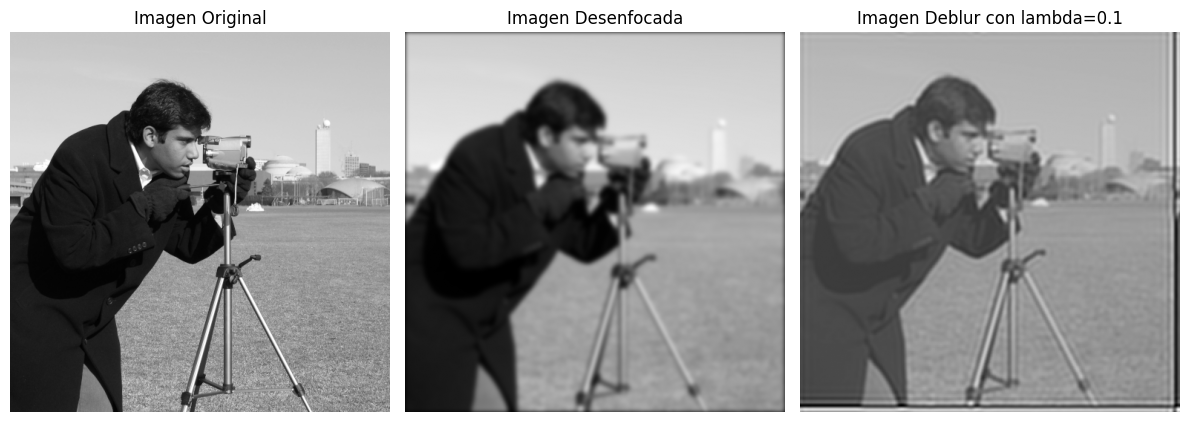

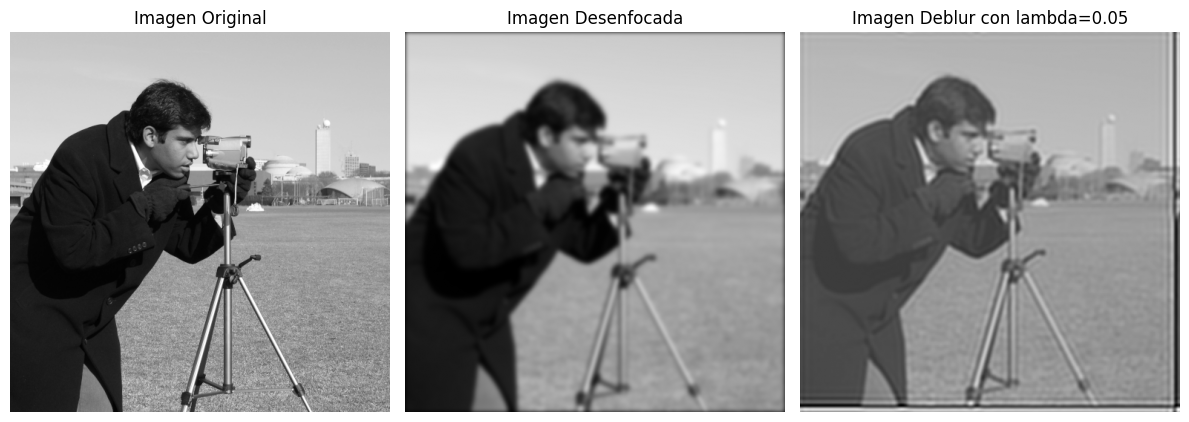

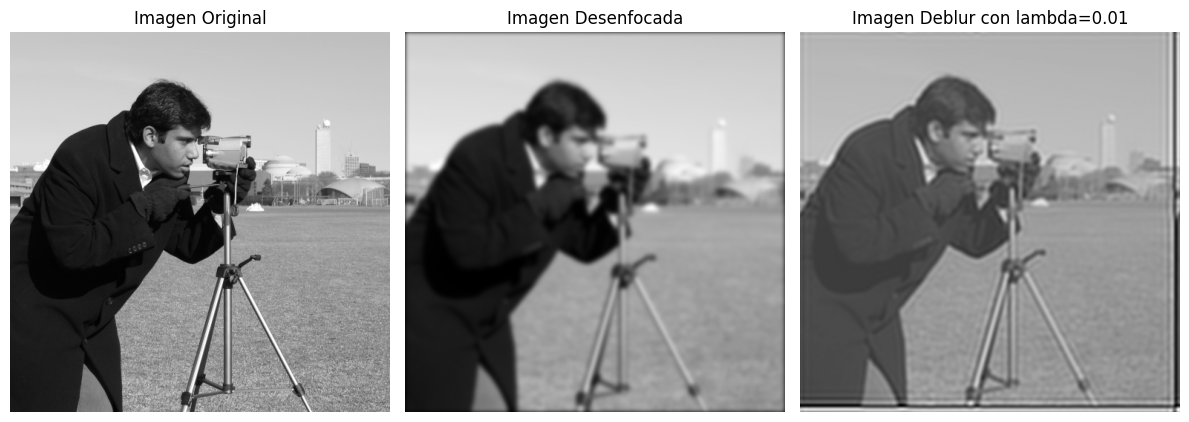

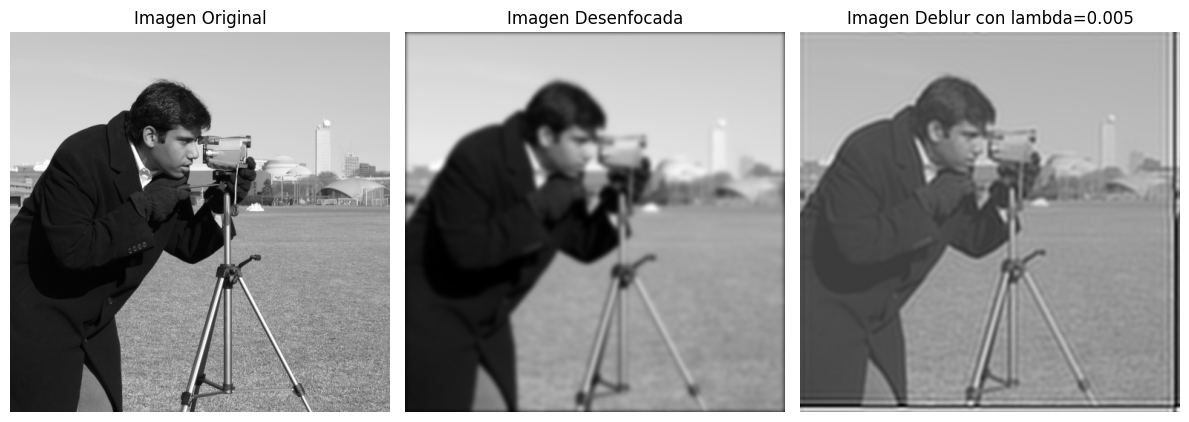

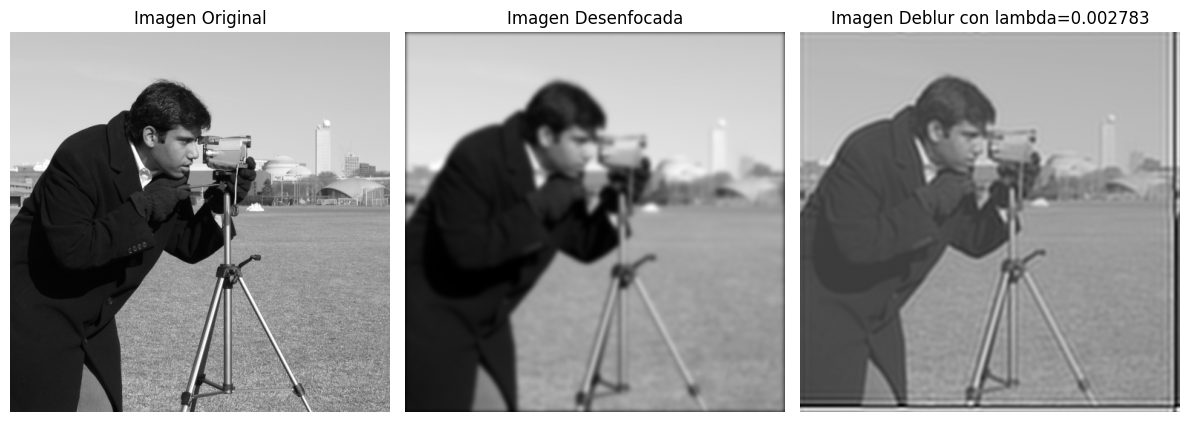

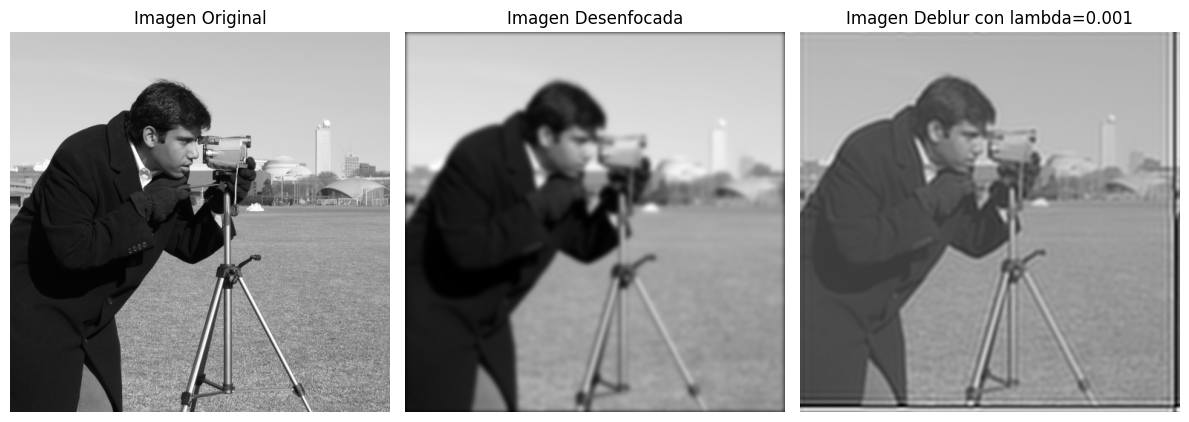

In [8]:
# Probar diferentes valores de lambda_param
lambda_values = [0.001,0.002783, 0.005, 0.01, 0.05, 0.1]
sorted_lambda_values = sorted(lambda_values, reverse=True)
for lambda_val in sorted_lambda_values:
    deblurred_admm = admm_wavelet_deblur(blurred, blur_kernel, lambda_param=lambda_val, rho=5, iterations=300)
    # 2. Mostrar resultados
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.title('Imagen Original')
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Imagen Desenfocada')
    plt.imshow(blurred, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f'Imagen Deblur con lambda={lambda_val}')
    plt.imshow(deblurred_admm, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Métrica de Evaluación: PSNR

### Peak Signal-to-Noise Ratio (PSNR)

El PSNR es una métrica estándar para evaluar la calidad de reconstrucción:

$$\text{PSNR} = 10 \log_{10}\left(\frac{\text{MAX}^2}{\text{MSE}}\right) = 20 \log_{10}\left(\frac{\text{MAX}}{\sqrt{\text{MSE}}}\right)$$

donde:
- $\text{MAX}$ es el valor máximo posible del pixel
- $\text{MSE} = \frac{1}{N}\sum_{i=1}^N (x_i - \hat{x}_i)^2$ es el error cuadrático medio

**Mayor PSNR indica mejor calidad de reconstrucción.**

In [9]:
#psnr
def psnr(original, deblurred):
    mse = np.mean((original - deblurred) ** 2)
    if mse == 0:
        return float('inf')  # No error
    max_pixel = 255.0 if original.dtype == np.uint8 else 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

### Optimización del Parámetro λ

Utilizamos un barrido logarítmico de λ para encontrar el valor óptimo que maximiza el PSNR. El comportamiento típico es:

1. **λ muy pequeño:** PSNR bajo (poca eliminación de ruido/artifacts)
2. **λ óptimo:** PSNR máximo (balance ideal)
3. **λ muy grande:** PSNR decreciente (over-smoothing)

La curva PSNR vs λ generalmente tiene forma de campana invertida.

PSNR para lambda=0.100000: 15.72 dB
PSNR para lambda=0.071969: 15.73 dB
PSNR para lambda=0.051795: 15.73 dB
PSNR para lambda=0.037276: 15.73 dB
PSNR para lambda=0.026827: 15.73 dB
PSNR para lambda=0.019307: 15.73 dB
PSNR para lambda=0.013895: 15.73 dB
PSNR para lambda=0.010000: 15.73 dB
PSNR para lambda=0.007197: 15.73 dB
PSNR para lambda=0.005179: 15.73 dB
PSNR para lambda=0.003728: 15.73 dB
PSNR para lambda=0.002683: 15.73 dB
PSNR para lambda=0.001931: 15.73 dB
PSNR para lambda=0.001389: 15.73 dB
PSNR para lambda=0.001000: 15.73 dB


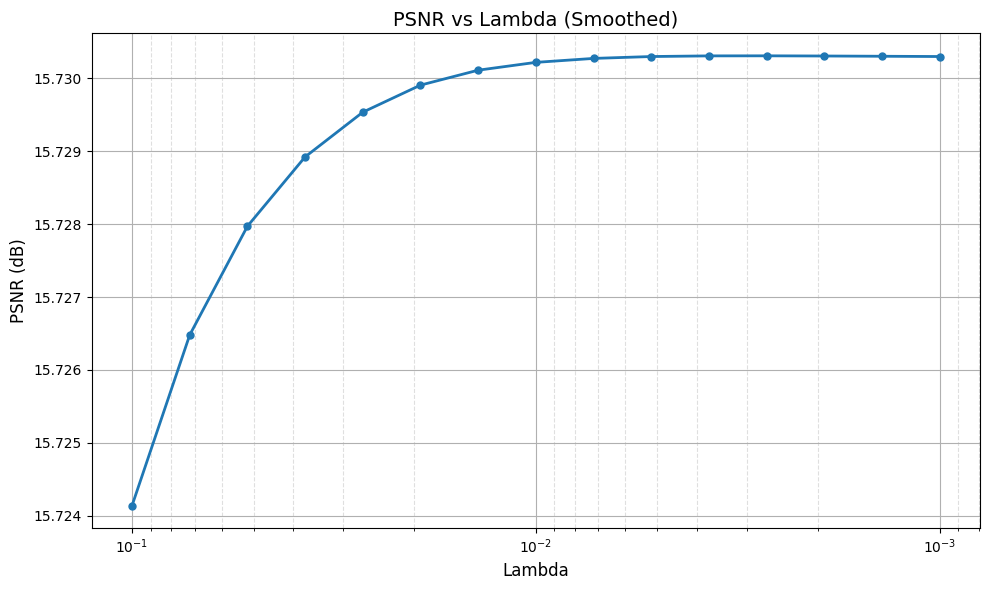

In [10]:

# Calculate PSNR for each lambda value  
lambda_values = np.logspace(-1, -3, 15)  # 15 points logarithmically spaced from 10^-1 to 10^-3
psnr_values = []

for lambda_val in lambda_values:
    deblurred_admm = admm_wavelet_deblur(blurred, blur_kernel, lambda_param=lambda_val)
    psnr_value = psnr(original, deblurred_admm)
    psnr_values.append(psnr_value)
    print(f'PSNR para lambda={lambda_val:.6f}: {psnr_value:.2f} dB')

# Plot PSNR vs lambda with smooth curve
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, psnr_values, marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title('PSNR vs Lambda (Smoothed)', fontsize=14)
plt.xlabel('Lambda', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.xscale('log')
plt.grid(True)
# Add minor grid lines
plt.gca().xaxis.grid(True, which='minor', linestyle='--', alpha=0.4)
# Reverse x-axis to show values from 10^-1 to 10^-3
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

PSNR% para iteración 1: 22.93 dB
PSNR% para iteración 2: 22.44 dB
PSNR% para iteración 3: 21.86 dB
PSNR% para iteración 4: 21.28 dB
PSNR% para iteración 5: 20.76 dB
PSNR% para iteración 6: 20.28 dB
PSNR% para iteración 7: 19.87 dB
PSNR% para iteración 8: 19.51 dB
PSNR% para iteración 9: 19.20 dB
PSNR% para iteración 10: 18.93 dB
PSNR% para iteración 11: 18.69 dB
PSNR% para iteración 12: 18.48 dB
PSNR% para iteración 13: 18.30 dB
PSNR% para iteración 14: 18.14 dB
PSNR% para iteración 15: 17.99 dB
PSNR% para iteración 16: 17.87 dB
PSNR% para iteración 17: 17.75 dB
PSNR% para iteración 18: 17.65 dB
PSNR% para iteración 19: 17.56 dB
PSNR% para iteración 20: 17.48 dB


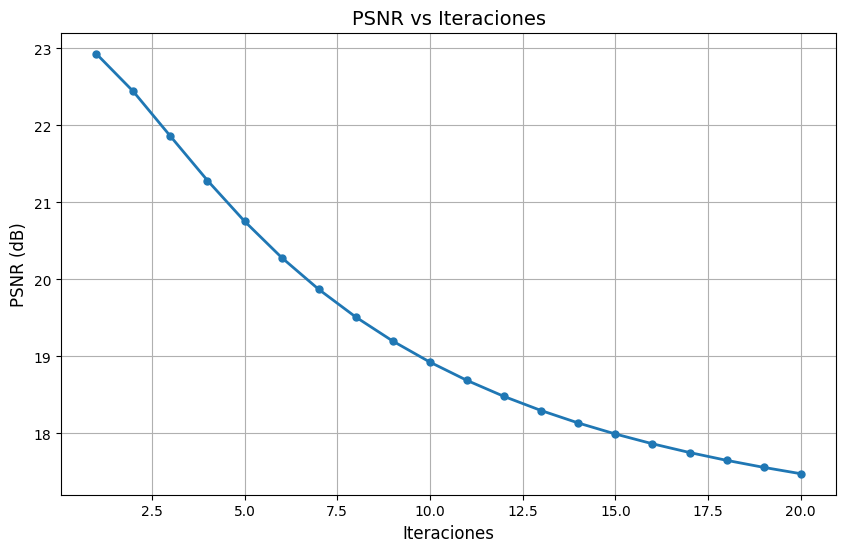

In [11]:
#psnr vs iterations
def psnr_vs_iterations(original, blurred, kernel, wavelet='bior1.3', lambda_param=0.002, rho=5.0, max_iterations=20):
    psnr_values = []
    for iteration in range(1, max_iterations + 1):
        deblurred = admm_wavelet_deblur(blurred, kernel, wavelet=wavelet, lambda_param=lambda_param, rho=rho, iterations=iteration)
        psnr_value = psnr(original, deblurred)
        psnr_values.append(psnr_value)
        print(f'PSNR% para iteración {iteration}: {psnr_value:.2f} dB')
    return psnr_values
# Calcular PSNR vs Iteraciones  
psnr_iterations = psnr_vs_iterations(original, blurred, blur_kernel, lambda_param=0.002, rho=5.0, max_iterations=20)
# Graficar PSNR vs Iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), psnr_iterations, marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title('PSNR vs Iteraciones', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.grid(True)